In [50]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from yf_utils import _2_split_train_val_test, _3_random_slices, _4_lookback_slices
from yf_utils import _5_perf_ranks, _6_grp_tuples_sort_sum
from myUtils import pickle_load, pickle_dump

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 14)
pd.set_option('display.max_colwidth', 12)
pd.set_option('display.width', 800)

verbose = False  # True prints more output
# verbose = True  # True prints more output

path_dir = "C:/Users/ping/MyDrive/stocks/yfinance/"
path_data_dump = path_dir + "VSCode_dump/"
fp_df_close_clean = 'df_close_clean'
fp_df_eval_results = 'df_eval_results'

df_close_clean = pickle_load(path_data_dump, fp_df_close_clean)

In [51]:
# Split df_close_clean into training (df_train), validation (df_val) and test (df_test) set.
# The default split is 0.7, 0.2, 0.1 respectively.

###################################
# df_train, df_val, df_test = _2_split_train_val_test(df_close_clean, s_train=1, s_val=0, s_test=0)
df_train, df_val, df_test = _2_split_train_val_test(df_close_clean)
###################################

len_df_train = len(df_train)
len_df_val = len(df_val)
len_df_test = len(df_test)
print(f'len_df_train: {len_df_train}, len_df_val: {len_df_val}, len_df_test: {len_df_test} ')

len_df_train: 1050, len_df_val: 300, len_df_test: 150 


In [52]:
# if store_results:  # record results to df
# my_cols = ['n_samples', 'days_lookbacks', 'days_eval', 'n_top_syms', 'syms_start', 'syms_end', 'grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'grp(CAGR/UI)_mean/std', 'SPY_CAGR/UI']
df_eval_results = pickle_load(path_data_dump, fp_df_eval_results)

In [53]:
# write run results to df_eval_results
store_results = False
# store_results = True

# number of max lookback tuples to create for iloc start_train:end_train:end_eval
# i.e. number of grp_top_set_syms_n_freq and grp_top_set_syms 
# n_samples = 400  
n_samples = 10

# for training, the number of days to lookback from iloc max-lookback end_train
# days_lookbacks = [15, 30, 60, 120]
# days_lookbacks = [30, 60, 120]
days_lookbacks = [60, 120]
# days_lookbacks = [120]
days_lookbacks.sort()

# number of days from end_train are used to evaluate effectiveness of the training
days_eval = 10  

# number of the most-common symbols from days_lookbacks' performance rankings to keep
# n_top_syms = 5
n_top_syms = 10  

syms_start = 0  #  start index of n_top_syms for evaluation
syms_end = 5  #  end index of n_top_syms for evaluation

create a sets of iloc lookback slices (start_train:end_train:end_eval), where  
end_train - start_train = days_lookback  
end_eval - end_train = days_eval  
for example,  
if given:  
 n_samples = 2  
 days_lookbacks = [30, 60, 120]  
 days_eval = 10  
a possible result is:  
 max_lookback_slices:  
 [(150, 270, 280), (5, 125, 135)]  
 where 270-150=125-5=max(days_lookbacks), 280-270=135-125=days_eval  
 sets_lookback_slices:  
 [[(240, 270, 280), (210, 270, 280), (150, 270, 280)], [(95, 125, 135), (65, 125, 135), (5, 125, 135)]]  
  where in a set, 270-240=days_lookbacks[0], 270-210=days_lookbacks[1], 270-150=days_lookbacks[2]  
  and 270, i.e. end_train, is constant for the set  

In [54]:
max_lookback_slices = _3_random_slices(len_df_train, n_samples=n_samples, days_lookback=max(days_lookbacks), days_eval=days_eval)
sets_lookback_slices = _4_lookback_slices(max_slices=max_lookback_slices, days_lookbacks=days_lookbacks, verbose=False)

if verbose:
  print(f'max_lookback_slices:\n{max_lookback_slices}')
  print(f'sets_lookback_slices:\n{sets_lookback_slices}')

Generate lists, n_samples long, of the highest performance ranked symbols. The performance metrics are: CAGR/UI, CAGR/retnStd, retnStd/UI. n_top_syms of the best performing symbols from each metric are combined. The symbols are sorted by their number of appearances in the combined pool, and are placed in a list. A slice of the best performing symbols is selected by syms_start:syms_end, i.e. top_set_syms_n_freq[syms_start:syms_end].     

The performance metrics are calculated based on slices in sets_lookback_slices.  The first two numbers are ilocs for training. The last two numbers are ilocs for evaluation.

In [55]:
grp_top_set_syms_n_freq = []  # list of lists of top_set_symbols_n_freq, there are n_samples lists in list
grp_top_set_syms = []  # list of lists of top_set_symbols, there are n_samples lists in list
# loop thru lists of tuples of start_train:end_train:end_eval, i.e.
#  [[(887, 917, 927), (857, 917, 927), (797, 917, 927)],
#  [(483, 513, 523), (453, 513, 523), (393, 513, 523)]]
for lb_slices in sets_lookback_slices:
  grp_most_common_syms = []  
  for lb_slice in lb_slices:  # lb_slice, e.g. (246, 276, 286)
    start_train = lb_slice[0]
    end_train = lb_slice[1]
    start_eval = end_train
    end_eval = lb_slice[2]
    lookback = end_train - start_train
    d_eval = end_eval - start_eval

    if verbose:
      print(f'days lookback: {lookback}')
      print(f'lb_slices:     {lb_slices}')
      print(f'lb_slice:      {lb_slice}')
      print(f'days eval:     {d_eval}')    
      print(f'start_train:   {start_train}')
      print(f'end_train:     {end_train}')
      # print(f'start_eval:    {start_eval}')
      # print(f'end_eval:      {end_eval}')`

    _df = df_train.iloc[start_train:end_train]
    perf_ranks, most_common_syms = _5_perf_ranks(_df, n_top_syms=n_top_syms)
    grp_most_common_syms.append(most_common_syms)
    
    if verbose:    
      # 1 lookback of r_CAGR/UI, r_CAGR/retnStd, r_retnStd/UI
      print(f'perf_ranks: {perf_ranks}')  
      # most common symbols of perf_ranks 
      print(f'most_common_syms: {most_common_syms}')     
      # grp_perf_ranks[lookback] = perf_ranks
      print(f'+++ finish lookback slice {lookback} +++\n')

  if verbose:
    print(f'grp_most_common_syms: {grp_most_common_syms}')
    # grp_most_common_syms a is list of lists of tuples of 
    #  the most-common-symbols symbol:frequency cumulated from
    #  each days_lookback  
    print(f'**** finish lookback slices {lb_slices} ****\n')

  # flatten list of lists of (symbol:frequency)
  flat_grp_most_common_syms = [val for sublist in grp_most_common_syms for val in sublist]
  # group symbols from set of days_lookbacks (i.e. lb_slices) and sum frequency of the symbols
  set_most_common_syms = _6_grp_tuples_sort_sum(flat_grp_most_common_syms, reverse=True)
  # get the top few most-frequent symbol:frequency pairs
  top_set_syms_n_freq = set_most_common_syms[0:n_top_syms]
  # get symbols from top_set_syms_n_freq

###################################  
  # top_set_syms = [i[0] for i in top_set_syms_n_freq]
  top_set_syms = [i[0] for i in top_set_syms_n_freq[syms_start:syms_end]]  
###################################  
  
  grp_top_set_syms_n_freq.append(top_set_syms_n_freq)
  grp_top_set_syms.append(top_set_syms)

  if verbose:  
    print(f'top {n_top_syms} ranked symbols and frequency from set {lb_slices}:\n{top_set_syms_n_freq}')
    print(f'top {n_top_syms} ranked symbols from set {lb_slices}:\n{top_set_syms}')  
    print(f'===== finish top {n_top_syms} ranked symbols from days_lookback set {lb_slices} =====\n\n')

In [56]:
print('z_grp_top_set_syms:')
z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms)
for item in z_grp_top_set_syms:
  print(item)
print('')

z_grp_top_set_syms:
((560, 680, 690), ['FTSM', 'IRT', 'BEP', 'ETN', 'NTRA'])
((188, 308, 318), ['VIRT', 'AXON', 'TNDM', 'ENPH', 'ETSY'])
((900, 1020, 1030), ['ACRS', 'CTRN', 'GME', 'MARA', 'SM'])
((74, 194, 204), ['OSTK', 'ALGN', 'GDS', 'ENPH', 'PRGS'])
((385, 505, 515), ['AXSM', 'SBS', 'AU', 'LRN', 'APPS'])
((341, 461, 471), ['FTSM', 'MKC', 'APPS', 'GOLD', 'LRN'])
((734, 854, 864), ['NVAX', 'CELH', 'OSTK', 'CWH', 'TDOC'])
((403, 523, 533), ['AXSM', 'FTSM', 'LRN', 'RCII', 'APPS'])
((6, 126, 136), ['FOLD', 'ALGN', 'CYRX', 'EVRI', 'FTSM'])
((67, 187, 197), ['OSTK', 'CAT', 'GDS', 'PRGS', 'QNST'])
((809, 929, 939), ['APPS', 'GOGO', 'HIBB', 'SPWR', 'DQ'])
((672, 792, 802), ['TDOC', 'CCOI', 'EVBG', 'NVAX', 'REGN'])
((869, 989, 999), ['CHRD', 'CLF', 'CTRN', 'MARA', 'NTLA'])
((859, 979, 989), ['CHRD', 'MARA', 'CPRI', 'JOE', 'LOB'])
((640, 760, 770), ['TSLA', 'ISEE', 'AAPL', 'AXSM', 'DOOR'])
((535, 655, 665), ['FTSM', 'SHAK', 'ARMK', 'ETN', 'MTH'])
((66, 186, 196), ['OSTK', 'PRGS', 'CAT', 'QNST

In [57]:
from yf_utils import _7_perf_eval

print('z_grp_top_set_syms:')
z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms)
# z_grp_top_set_syms = zip(max_lookback_slices, grp_top_set_syms[26:29])

for i, (_lookback_slice, _top_set_syms) in enumerate(z_grp_top_set_syms):
# for i, (_lookback_slice, _top_set_syms) in enumerate(z_grp_top_set_syms[26:29]):

  start_train = _lookback_slice[0]
  end_train = _lookback_slice[1]
  start_eval = end_train
  end_eval = _lookback_slice[2]

  print(f'{i + 1 } of {n_samples} max_lookback_slice')
  print(f'max_lookback_slice: {_lookback_slice}')
  # dates correspond to max_lookback_slice
  d_start_train = df_train.index[start_train].strftime('%Y-%m-%d')
  d_end_train = df_train.index[end_train].strftime('%Y-%m-%d')
  d_start_eval = d_end_train
  d_end_eval = df_train.index[end_eval].strftime('%Y-%m-%d')
  d_df_eval_start = d_end_train
  d_df_eval_end = df_train.index[end_eval - 1].strftime('%Y-%m-%d')  
  print(f'max lookback dates: {d_start_train}, {d_end_train}, {d_end_eval}')
  print(f'df_eval dates (inclusive): {d_df_eval_start} - {d_df_eval_end}')    
  print(f'top_set_syms: {_top_set_syms}\n')

  df_eval = df_train[start_eval:end_eval][_top_set_syms]

  if verbose:
    # print(f'start_eval: {start_eval}')
    # print(f'end_eval:   {end_eval}')  
    print(f'start_eval: {start_eval},  date: {d_end_train}')
    print(f'end_eval:   {end_eval},  date: {d_end_eval},  df_eval last date: {d_df_eval_end}')      
    print(f'\ndf_eval:\n{df_eval}\n')


  _, grp_retnStd_d_UI, grp_CAGR_d_retnStd, grp_CAGR_d_UI = _7_perf_eval(df_eval)
  print(f'grp(retnStd/UI):   mean, std, mean/std: {grp_retnStd_d_UI[0]:>13,.3f}, {grp_retnStd_d_UI[1]:>13,.3f}, {grp_retnStd_d_UI[2]:>13,.3f}')
  print(f'grp(CAGR/retnStd): mean, std, mean/std: {grp_CAGR_d_retnStd[0]:>13,.3f}, {grp_CAGR_d_retnStd[1]:>13,.3f}, {grp_CAGR_d_retnStd[2]:>13,.3f}')
  print(f'grp(CAGR/UI):      mean, std, mean/std: {grp_CAGR_d_UI[0]:>13,.3f}, {grp_CAGR_d_UI[1]:>13,.3f}, {grp_CAGR_d_UI[2]:>13,.3f}')

  _sym_idx = ['SPY']
  df_SPY = df_train[start_eval:end_eval][_sym_idx]
  _, SPY_retnStd_d_UI, SPY_CAGR_d_retnStd, SPY_CAGR_d_UI = _7_perf_eval(df_SPY)
  print(f'\nSPY: retnStd/UI, CAGR/retnStd, CAGR/UI: {SPY_retnStd_d_UI[0]:>13,.3f}, {SPY_CAGR_d_retnStd[0]:>13,.3f}, {SPY_CAGR_d_UI[0]:>13,.3f}')

  if store_results:  # record results to df
    row_add = [n_samples, str(days_lookbacks), days_eval, n_top_syms, syms_start, syms_end, grp_CAGR_d_UI[0], grp_CAGR_d_UI[1], grp_CAGR_d_UI[2], SPY_CAGR_d_UI[0]]
    df_eval_results.loc[len(df_eval_results)] = row_add
    print(f'appended row_add to df_eval_results:\n{row_add}\n')
  print('='*50, '\n')  

z_grp_top_set_syms:
1 of 400 max_lookback_slice
max_lookback_slice: (560, 680, 690)
max lookback dates: 2019-05-01, 2019-10-21, 2019-11-04
df_eval dates (inclusive): 2019-10-21 - 2019-11-01
top_set_syms: ['FTSM', 'IRT', 'BEP', 'ETN', 'NTRA']

grp(retnStd/UI):   mean, std, mean/std:         1.525,         0.712,         2.140
grp(CAGR/retnStd): mean, std, mean/std:        93.569,       162.915,         0.574
grp(CAGR/UI):      mean, std, mean/std:       213.390,       376.609,         0.567

SPY: retnStd/UI, CAGR/retnStd, CAGR/UI:         2.966,       167.822,       497.813
appended row_add to df_eval_results:
[400, '[60, 120]', 10, 10, 0, 5, 213.3901060144086, 376.60852529155704, 0.5666098659057426, 497.81339752537883]


2 of 400 max_lookback_slice
max_lookback_slice: (188, 308, 318)
max lookback dates: 2017-11-03, 2018-04-30, 2018-05-14
df_eval dates (inclusive): 2018-04-30 - 2018-05-11
top_set_syms: ['VIRT', 'AXON', 'TNDM', 'ENPH', 'ETSY']

grp(retnStd/UI):   mean, std, mean/std:    

In [63]:
# https://towardsdatascience.com/pandas-groupby-a-simple-but-detailed-tutorial-314b8f37005d
# https://towardsdatascience.com/accessing-data-in-a-multiindex-dataframe-in-pandas-569e8767201d
# https://towardsdatascience.com/summarizing-data-with-pandas-crosstab-efc8b9abecf
# https://towardsdatascience.com/how-to-flatten-multiindex-columns-and-rows-in-pandas-f5406c50e569
# https://datascientyst.com/list-aggregation-functions-aggfunc-groupby-pandas/

In [64]:
# df = pickle_load(path_data_dump, 'df_eval_results')
df = df_eval_results.copy()
display(HTML(df.to_html()))

,n_samples,days_lookbacks,days_eval,n_top_syms,syms_start,syms_end,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,grp(CAGR/UI)_mean/std,SPY_CAGR/UI
0,400,"[15, 30, 60, 120]",10,10,0,5,2.484900e+02,5.848435e+02,0.424883,-30.375669
1,400,"[15, 30, 60, 120]",10,10,0,5,3.192784e+01,6.022934e+01,0.530105,-10.581483
2,400,"[15, 30, 60, 120]",10,10,0,5,4.008400e+03,5.423419e+03,0.739091,190.881313
3,400,"[15, 30, 60, 120]",10,10,0,5,3.735447e+03,8.000659e+03,0.466892,289.043187
4,400,"[15, 30, 60, 120]",10,10,0,5,-6.004549e+00,1.647551e+01,-0.364453,-12.457626
5,400,"[15, 30, 60, 120]",10,10,0,5,1.571464e+03,2.628188e+03,0.597927,554.362350
6,400,"[15, 30, 60, 120]",10,10,0,5,2.009204e+04,4.422272e+04,0.454338,-23.309573
7,400,"[15, 30, 60, 120]",10,10,0,5,1.280673e+02,2.452417e+02,0.522208,-20.544446
8,400,"[15, 30, 60, 120]",10,10,0,5,6.493718e+02,1.395494e+03,0.465335,350.576961
9,400,"[15, 30, 60, 120]",10,10,0,5,1.561127e+05,3.485275e+05,0.447921,-33.378823


In [65]:
my_cols = ['grp(CAGR/UI)_mean', 'grp(CAGR/UI)_std', 'SPY_CAGR/UI']
_df = df[my_cols]
row_inf = _df.index[np.isinf(_df).any(axis=1)]
print(f'row iloc with inf:\n{row_inf}\n')
df_inf = df.iloc[row_inf].copy()  # df with inf in my_cols
# display(HTML(df_inf.to_html()))
df.drop(axis=0, index=row_inf, inplace=True)
# display(HTML(df.to_html()))
df.dropna(how='any', inplace=True)
df

row iloc with inf:
Int64Index([25, 26, 38, 52, 65, 73, 76, 84, 100, 110, 131, 139, 149, 223, 225, 244, 266, 346, 349, 358, 384, 393, 405, 411, 412, 418, 419, 440, 473, 478, 496, 511, 525, 533, 535, 540, 554, 581, 586, 587, 590, 619, 623, 627, 629, 633, 681, 683, 684, 706, 727, 750, 763, 784, 801, 807, 815, 852, 859, 860, 902, 909, 929, 975, 977, 979, 996, 1044, 1055, 1068, 1089, 1122, 1140, 1147, 1154, 1158, 1182, 1183], dtype='int64')



,n_samples,days_lookbacks,days_eval,n_top_syms,syms_start,syms_end,grp(CAGR/UI)_mean,grp(CAGR/UI)_std,grp(CAGR/UI)_mean/std,SPY_CAGR/UI
0,400,"[15, 30,...",10,10,0,5,248.489978,584.843540,0.424883,-30.375669
1,400,"[15, 30,...",10,10,0,5,31.927844,60.229337,0.530105,-10.581483
2,400,"[15, 30,...",10,10,0,5,4008.399882,5423.419446,0.739091,190.881313
3,400,"[15, 30,...",10,10,0,5,3735.447231,8000.658763,0.466892,289.043187
4,400,"[15, 30,...",10,10,0,5,-6.004549,16.475508,-0.364453,-12.457626
...,...,...,...,...,...,...,...,...,...,...
1195,400,"[60, 120]",10,10,0,5,137.883930,215.784700,0.638988,225.888250
1196,400,"[60, 120]",10,10,0,5,108.712318,255.966860,0.424712,83.090837
1197,400,"[60, 120]",10,10,0,5,105.432307,257.506197,0.409436,199.360271
1198,400,"[60, 120]",10,10,0,5,862.459357,1095.661575,0.787159,624.093993


In [70]:
# pd.crosstab(df['days_lookbacks'], df['grp(CAGR/UI)_mean'])
tbl = df.groupby(['days_lookbacks'])\
        .agg({'grp(CAGR/UI)_mean': ['mean', 'std'],
              'grp(CAGR/UI)_mean/std': ['mean', 'std'],
              'SPY_CAGR/UI': ['mean', 'std']})

In [71]:
tbl

grp(CAGR/UI)_mean              grp(CAGR/UI)_mean/std           SPY_CAGR/UI            
                          mean          std                  mean       std        mean         std
days_look...                                                                                       
[15, 30, ...  3.579270...       3.953039...     0.216957           1.438915  268.776613  682.682971
[30, 60, ...  2.215328...       2.629466...     0.257756           0.997108  266.594045  675.322106
[60, 120]     1.021825...       1.505096...     0.273730           1.021185  276.295485  746.138692

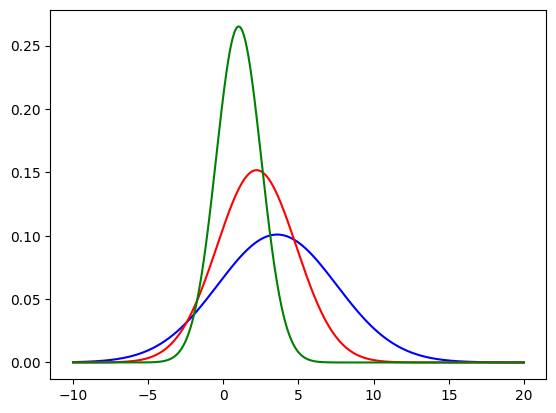

In [72]:
import pylab
import numpy as np
from scipy.stats import norm
x = np.linspace(-10,20,1000)
y = norm.pdf(x, loc=3.579270, scale=3.953039)    # for example
z = norm.pdf(x, loc=2.215328, scale=2.629466)    # for example
z1 = norm.pdf(x, loc=1.021825, scale=1.505096)    # for example
pylab.plot(x,y, 'b')
pylab.plot(x,z, 'r')
pylab.plot(x,z1, 'g')
pylab.show()

In [69]:
# print(f'n_samples:             {n_samples:>13}')
# print(f'days_lookbacks:        {days_lookbacks}')
# print(f'days_eval:             {days_eval:>13}')
# print(f'n_top_syms:            {n_top_syms:>13}')
# print(f'syms_start:            {syms_start:>13}')
# print(f'syms_end:              {syms_end:>13}')
# print(f'grp(CAGR/UI)_mean:     {grp_CAGR_d_UI[0]:>13,.3f}')
# print(f'grp(CAGR/UI)_std:      {grp_CAGR_d_UI[1]:>13,.3f}')
# print(f'grp(CAGR/UI)_mean/std: {grp_CAGR_d_UI[2]:>13,.3f}')
# print(f'SPY_CAGR/UI:           {SPY_CAGR_d_UI[0]:>13,.3f}')